In [79]:
import os
import pandas as pd
import dask.dataframe as dd
from s3fs import S3FileSystem
import numpy as np
import coiled
from distributed import Client
import matplotlib.pyplot as plt

In [ ]:
cluster = coiled.Cluster(
    # worker_vm_types=["m6i.4xlarge"],
    worker_vm_types=["m6i.xlarge"],
    scheduler_vm_types=["m6i.2xlarge"],
    name="dask-engineering-20d6aa4e-3",
    package_sync=True, # copy local packages,
    shutdown_on_close=False,  # reuse cluster across runs
    show_widget=False,
    n_workers=20,
    use_best_zone=True,
    account="dask-engineering",
    backend_options={"region": "us-east-2", "spot": True, "spot_on_demand_fallback": True}
    )

In [ ]:
client = Client(cluster)
client

In [ ]:
def subset_data():
    print("loading data")
    to_exclude=["string", "category", "object"]
    ddf= dd.read_parquet("s3://prefect-dask-examples/nyc-uber-lyft/processed_files.parquet")
    # ddf = ddf.drop(columns=["base_passenger_fare", "sales_tax", "bcf", "congestion_surcharge", "tips", "driver_pay", "dropoff_datetime"])
    ddf = ddf.assign(accessible_vehicle = 1)
    print("Make accessible feature")
    ddf.accessible_vehicle = ddf.accessible_vehicle.where(ddf.on_scene_datetime.isnull(),0)  # Only applies if the vehicle is wheelchair accessible
    ddf = ddf.assign(pickup_month = ddf.pickup_datetime.dt.month)
    ddf = ddf.assign(pickup_dow = ddf.pickup_datetime.dt.dayofweek)
    ddf = ddf.assign(pickup_hour = ddf.pickup_datetime.dt.hour)
    
    ddf = ddf.drop(columns=['on_scene_datetime', 'request_datetime',
                            'pickup_datetime', 'dispatching_base_num',
                            'originating_base_num', 'shared_request_flag',
                           'shared_match_flag' 'dropoff_datetime',
                           ]
                  )

    ddf = ddf.dropna(how="any")
    ddf = ddf.repartition(partition_size="128MB")
    ddf = ddf.reset_index(drop=True)

    categories = ["pickup_month", "pickup_dow", "pickup_hour",
                 "dropoff_month", "dropoff_dow", "dropoff_hour",
                 "hvfhs_license_num",]
    for cat in categories:
        ddf[cat] = ddf[cat].astype('category')
    ddf = ddf.categorize(columns=categories)

    df = ddf.sample(frac=0.0025).compute()
    df.to_parquet("data/rides.parquet")

In [ ]:
subset_data()

In [ ]:
client.close()
cluster.shutdown()

### Let's grab some information about taxi shapefiles and boroughs

In [80]:
taxi_df = pd.read_csv("data/taxi+_zone_lookup.csv", usecols=["LocationID", "Borough"])
taxi_df.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [81]:
# These are the unique Boroughs in the taxi zone lookup table
taxi_df.Borough.unique().tolist()

['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn', 'Unknown']

The taxi_df includes two `LocationID` values that correspond to `Unknown` Boroughs.  
We need to know if these exist in the dataset

In [82]:
taxi_df.loc[taxi_df['Borough'] == "Unknown"]

,LocationID,Borough
263,264,Unknown
264,265,Unknown


## Let's take a look at the distribution of travel times and the presence of `Unknown` boroughs

In [89]:
df = pd.read_parquet("data/rides.parquet").reset_index(drop=True)
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,access_a_ride_flag,wav_request_flag,wav_match_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour
0,HV0003,2019-04-02 22:36:00,235,136,1.55,467,6.48,0.0,0.16,0.58,...,,N,,0,4,1,22,4,1,22
1,HV0003,2019-04-07 21:17:15,164,233,1.13,573,8.54,0.0,0.21,0.76,...,,N,,0,4,6,21,4,6,21
2,HV0003,2019-04-08 00:15:56,40,257,3.60,546,4.75,0.0,0.12,0.42,...,,N,,0,4,0,0,4,0,0
3,HV0003,2019-04-02 21:24:42,168,69,2.12,699,9.01,0.0,0.23,0.80,...,,N,,0,4,1,21,4,1,21
4,HV0003,2019-04-03 06:41:02,141,161,1.74,514,6.00,0.0,0.16,0.58,...,,N,,0,4,2,6,4,2,6


In [90]:
len(df.index)

1622870

In [91]:
df.memory_usage(deep=True).sum() / 2**20

599.0724143981934

We can see from below that over 9000 entries exist where travel occurs in or out of a borough that 
is an `Unknown` zone.

In [92]:
df.loc[df.PULocationID.isin([263, 264])]

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,access_a_ride_flag,wav_request_flag,wav_match_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour
147,HV0003,2019-04-03 07:55:07,263,236,0.590,495,4.53,0.0,0.12,0.44,...,,N,,0,4,2,7,4,2,7
511,HV0005,2021-04-10 18:16:44,263,140,0.665,301,9.16,0.0,0.27,0.81,...,N,N,N,1,4,5,18,4,5,18
650,HV0003,2021-04-10 16:48:36,263,265,8.510,2968,48.13,20.0,2.04,0.00,...,,N,N,0,4,5,15,4,5,16
802,HV0003,2021-04-10 19:50:42,263,144,6.590,1221,28.11,0.0,0.84,2.49,...,,N,N,0,4,5,19,4,5,19
877,HV0005,2021-04-10 18:21:10,263,230,3.853,1005,21.81,0.0,0.65,1.94,...,N,N,N,1,4,5,18,4,5,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621703,HV0005,2021-02-05 09:09:02,263,100,3.232,1608,18.53,0.0,0.56,1.65,...,N,N,N,1,2,4,8,2,4,9
1622246,HV0003,2019-04-01 14:09:47,263,140,2.450,976,16.01,0.0,0.40,1.42,...,,N,,0,4,0,13,4,0,14
1622279,HV0003,2019-04-03 17:13:58,263,265,12.890,3453,65.42,20.0,2.14,0.00,...,,N,,0,4,2,16,4,2,17
1622656,HV0003,2019-04-03 07:32:45,263,140,1.410,466,8.61,0.0,0.22,0.76,...,,N,,0,4,2,7,4,2,7


## We can see from the below that, as expected, our travel times are not normally distributed

<AxesSubplot: >

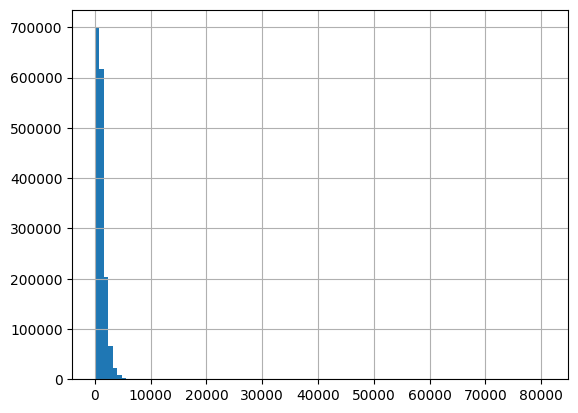

In [93]:
df['trip_time'].hist(bins=100)

In [94]:
df['trip_time'].min()

0

In [95]:
df['trip_time'].max()

80807

We need to filter outliers from our data.  For this exercise, we will use `1.5 * Interquartile Range`
We can find the bounds using `df.quartile(method="median_unbiased")`.

In [96]:
Q1 = df['trip_time'].quantile(0.25, interpolation="median_unbiased")
Q3 = df['trip_time'].quantile(0.75, interpolation="median_unbiased")
print(f"Q1:  {Q1}, Q3:  {Q3}")

Q1:  576.0, Q3:  1415.0


As a check -- when porting code from Pandas to Dask, it was discovered that the Dask quantiles method does not
exactly replicate the Pandas / Numpy method.  See [here](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.quantile.html) and 
[here](https://github.com/dask/dask/issues/6566) for details.  Let's compare the results of the Dask and Pandas implementations 

In [97]:
print(f"Using the `dask` method:  {dd.from_pandas(df['trip_time'], npartitions=4).quantile(0.75).compute()}")
# print(f"Using the `tdigest` method:  {dd.from_pandas(df['trip_time'], npartitions=1).quantile(0.75, method='tdigest').compute()}")

Using the `dask` method:  1442.0


Let's plot the upper and lower bounds, then filter the data.

In [98]:
lower_bound = Q1 - (1.5*(Q3 - Q1))
lower_bound = lower_bound if lower_bound > 0 else 0

upper_bound = Q3 + (1.5*(Q3 - Q1))
print(f"Lower bound is:  {lower_bound}")
print(f"Upper bound is:  {upper_bound}")

Lower bound is:  0
Upper bound is:  2673.5


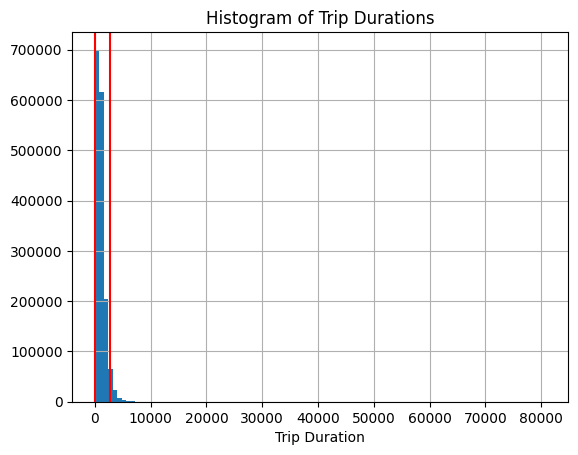

In [99]:
df['trip_time'].hist(bins=100)
plt.axvline(lower_bound, color="r")
plt.axvline(upper_bound, color="r")
plt.title("Histogram of Trip Durations")
plt.xlabel("Trip Duration")
plt.savefig("data/trip_histogram.png")

In [100]:
print(f"Fraction of data lost after filtering outliers:  {len(df.loc[df.trip_time > upper_bound].index) / len(df.index)}")

Fraction of data lost after filtering outliers:  0.04576090506325214


In [101]:
size_raw_data = len(df.index)

In [102]:
df = df.loc[(df.trip_time >= lower_bound) & (df.trip_time <= upper_bound)]

In [103]:
print(f"Fraction of data remaining after removing outliers:  {len(df.index) / size_raw_data}")

Fraction of data remaining after removing outliers:  0.9542390949367479


In [104]:
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,access_a_ride_flag,wav_request_flag,wav_match_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour
0,HV0003,2019-04-02 22:36:00,235,136,1.55,467,6.48,0.0,0.16,0.58,...,,N,,0,4,1,22,4,1,22
1,HV0003,2019-04-07 21:17:15,164,233,1.13,573,8.54,0.0,0.21,0.76,...,,N,,0,4,6,21,4,6,21
2,HV0003,2019-04-08 00:15:56,40,257,3.60,546,4.75,0.0,0.12,0.42,...,,N,,0,4,0,0,4,0,0
3,HV0003,2019-04-02 21:24:42,168,69,2.12,699,9.01,0.0,0.23,0.80,...,,N,,0,4,1,21,4,1,21
4,HV0003,2019-04-03 06:41:02,141,161,1.74,514,6.00,0.0,0.16,0.58,...,,N,,0,4,2,6,4,2,6


## Taking inspiration from [this paper on using geospatial characteristics to predict trip durations](https://amr4i.github.io/pdfs/nyc_taxi_times.pdf),   

We can assign each pickup and dropoff location to a `Superborough`, as defined by the following table.  To do this, we will  
add the PU and DO borough to each trip, then assign a Superborough.  We do this to determine if a trip occurs between 
Superboroughs

| Superborough    | Boroughs                 |
|-----------------| -------------------------|
| Superborough 1  | Manhattan, Bronx, & EWR  |
| Superborough 2  | Brooklyn & Queens        |
| Superborough 3  | Staten Island            |
| Unknown         | Unknown

In [105]:
df = pd.merge(df, taxi_df, left_on="PULocationID", right_on="LocationID", how="inner")
df = df.rename(columns={"Borough": "PUBorough"})
df = df.drop(columns="LocationID")
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,wav_request_flag,wav_match_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour,PUBorough
0,HV0003,2019-04-02 22:36:00,235,136,1.55,467,6.48,0.0,0.16,0.58,...,N,,0,4,1,22,4,1,22,Bronx
1,HV0003,2019-04-02 23:00:39,235,174,4.57,857,8.85,0.0,0.22,0.78,...,N,,0,4,1,22,4,1,23,Bronx
2,HV0003,2019-04-07 20:46:16,235,168,3.77,1213,6.60,0.0,0.16,0.59,...,N,,0,4,6,20,4,6,20,Bronx
3,HV0003,2021-04-10 21:07:29,235,169,1.26,605,9.84,0.0,0.30,0.87,...,N,N,0,4,5,20,4,5,21,Bronx
4,HV0003,2021-04-10 20:46:57,235,119,1.09,374,12.39,0.0,0.37,1.10,...,N,N,0,4,5,20,4,5,20,Bronx


In [106]:
df = pd.merge(df, taxi_df, left_on="DOLocationID", right_on="LocationID", how="inner")
df = df.rename(columns={"Borough": "DOBorough"})
df = df.drop(columns="LocationID")
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,wav_match_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour,PUBorough,DOBorough
0,HV0003,2019-04-02 22:36:00,235,136,1.55,467,6.48,0.0,0.16,0.58,...,,0,4,1,22,4,1,22,Bronx,Bronx
1,HV0003,2021-11-05 20:33:10,235,136,0.75,288,8.17,0.0,0.25,0.73,...,N,0,11,4,20,11,4,20,Bronx,Bronx
2,HV0003,2021-11-04 20:30:11,235,136,1.69,545,10.52,0.0,0.32,0.93,...,N,0,11,3,20,11,3,20,Bronx,Bronx
3,HV0003,2021-04-12 19:04:06,235,136,0.84,271,7.91,0.0,0.24,0.70,...,N,0,4,0,18,4,0,19,Bronx,Bronx
4,HV0003,2021-03-28 09:08:36,235,136,1.25,334,10.35,0.0,0.31,0.92,...,N,0,3,6,9,3,6,9,Bronx,Bronx


In [107]:
df.shape

(1548606, 26)

In [108]:
borough_mapping = {
    "Manhattan": "Superborough 1",
    "Bronx": "Superborough 1",
    "EWR": "Superborough 1",
    "Brooklyn": "Superborough 2",
    "Queens": "Superborough 2",
    "Staten Island": "Superborough 3",
    "Unknown": "Unknown",
}

In [109]:
PUSuperborough = [borough_mapping.get(x) for x in df.PUBorough.tolist()]
DOSuperborough = [borough_mapping.get(x) for x in df.DOBorough.tolist()]
cross_superborough = ["N" if i==j else "Y" for (i,j) in zip(PUSuperborough, DOSuperborough)]

In [110]:
df = df.assign(CrossSuperborough = cross_superborough)

In [111]:
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour,PUBorough,DOBorough,CrossSuperborough
0,HV0003,2019-04-02 22:36:00,235,136,1.55,467,6.48,0.0,0.16,0.58,...,0,4,1,22,4,1,22,Bronx,Bronx,N
1,HV0003,2021-11-05 20:33:10,235,136,0.75,288,8.17,0.0,0.25,0.73,...,0,11,4,20,11,4,20,Bronx,Bronx,N
2,HV0003,2021-11-04 20:30:11,235,136,1.69,545,10.52,0.0,0.32,0.93,...,0,11,3,20,11,3,20,Bronx,Bronx,N
3,HV0003,2021-04-12 19:04:06,235,136,0.84,271,7.91,0.0,0.24,0.70,...,0,4,0,18,4,0,19,Bronx,Bronx,N
4,HV0003,2021-03-28 09:08:36,235,136,1.25,334,10.35,0.0,0.31,0.92,...,0,3,6,9,3,6,9,Bronx,Bronx,N


In [112]:
c = df.columns.tolist()
c

['hvfhs_license_num',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag',
 'accessible_vehicle',
 'pickup_month',
 'pickup_dow',
 'pickup_hour',
 'dropoff_month',
 'dropoff_dow',
 'dropoff_hour',
 'PUBorough',
 'DOBorough',
 'CrossSuperborough']

<AxesSubplot: >

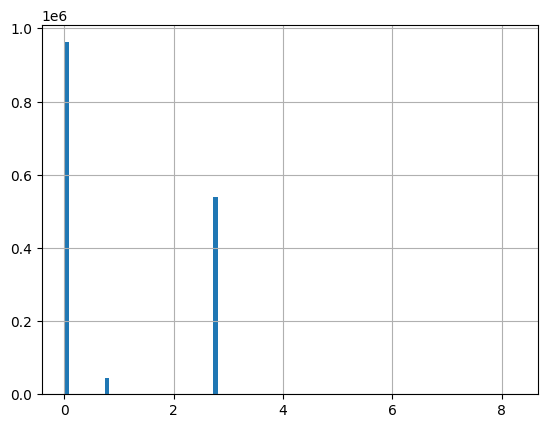

In [113]:
df['congestion_surcharge'].hist(bins=100)

<AxesSubplot: >

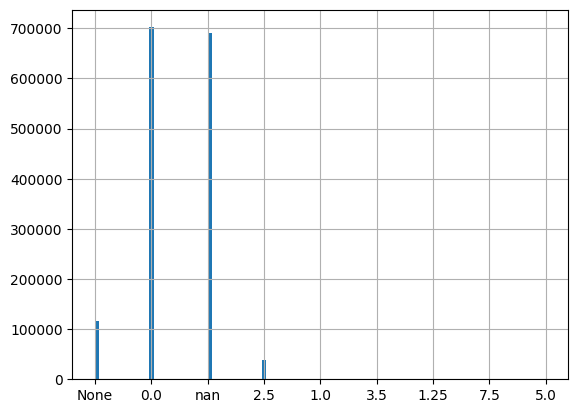

In [114]:
df['airport_fee'].hist(bins=100)

In [115]:
df['tolls'].value_counts()

0.00     1395823
6.55       33586
6.12       31220
20.00      12627
21.00       2154
          ...   
33.14          1
32.33          1
25.73          1
25.92          1
10.40          1
Name: tolls, Length: 2001, dtype: int64

<AxesSubplot: >

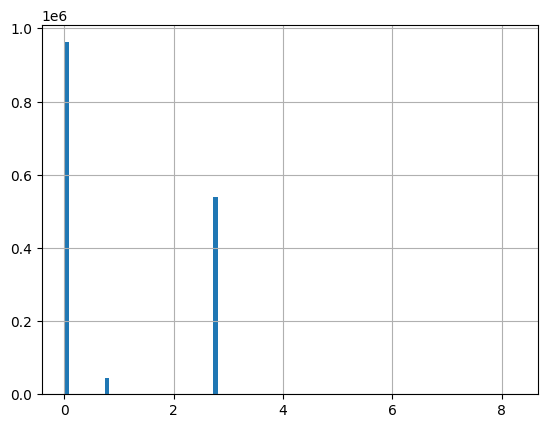

In [116]:
df['congestion_surcharge'].hist(bins=100)

In [117]:
df['CrossSuperborough'].value_counts()

N    1312639
Y     235967
Name: CrossSuperborough, dtype: int64

In [118]:
df.dtypes

hvfhs_license_num             category
dropoff_datetime        datetime64[ns]
PULocationID                     int64
DOLocationID                     int64
trip_miles                     float64
trip_time                        int64
base_passenger_fare            float64
tolls                          float64
bcf                            float64
sales_tax                      float64
congestion_surcharge           float64
airport_fee                     object
tips                           float64
driver_pay                     float64
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                  object
accessible_vehicle               int64
pickup_month                     int64
pickup_dow                       int64
pickup_hour                      int64
dropoff_month                    int64
dropoff_dow                      int64
dropoff_hour                     int64
PUBorough                       object
DOBorough                

## Final Cleanup

In [119]:
df['airport_fee'] = df['airport_fee'].replace("None", 0)
df['airport_fee'] = df['airport_fee'].replace('nan', 0)
df['airport_fee'] = df['airport_fee'].astype(float)

In [120]:
df['airport_fee'] = df['airport_fee'].fillna(0)

In [121]:
df.hvfhs_license_num.value_counts()

HV0003    1115004
HV0005     402035
HV0004      23619
HV0002       7948
Name: hvfhs_license_num, dtype: int64

In [122]:
df.wav_request_flag.value_counts()

N    1546960
Y       1646
Name: wav_request_flag, dtype: int64

In [123]:
df.wav_match_flag.value_counts()

N    1409335
       77281
Y      61990
Name: wav_match_flag, dtype: int64

In [124]:
df.CrossSuperborough.value_counts()

N    1312639
Y     235967
Name: CrossSuperborough, dtype: int64

In [125]:
df.access_a_ride_flag.value_counts()

     1114838
N     433768
Name: access_a_ride_flag, dtype: int64

<AxesSubplot: >

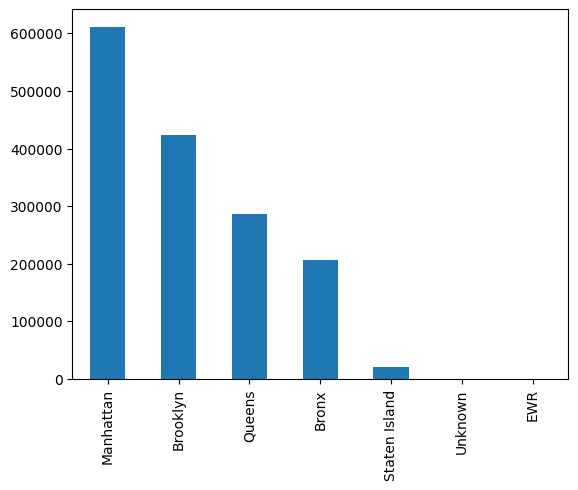

In [126]:
df.PUBorough.value_counts().plot(kind='bar')

<AxesSubplot: >

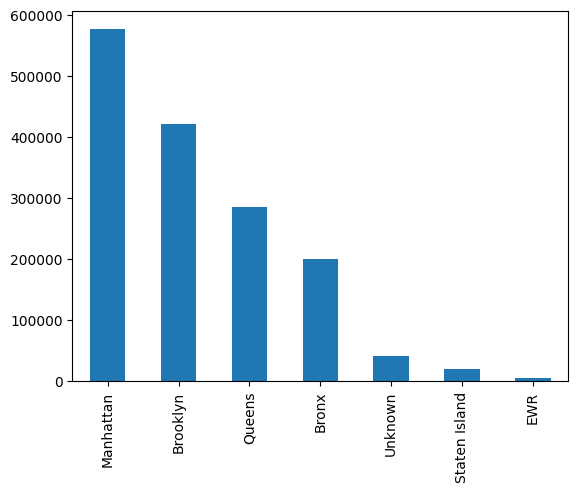

In [127]:
df.DOBorough.value_counts().plot(kind='bar')

In [128]:
to_drop = ['base_passenger_fare', 'dropoff_month', 'dropoff_dow', 'dropoff_hour',
           'bcf', 'sales_tax', 'tips', 'driver_pay', 'dropoff_datetime', 'access_a_ride_flag', 'wav_match_flag'
          ]

In [129]:
df2 = df.drop(columns=to_drop)

In [130]:
df2.head()

,hvfhs_license_num,PULocationID,DOLocationID,trip_miles,trip_time,tolls,congestion_surcharge,airport_fee,wav_request_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,PUBorough,DOBorough,CrossSuperborough
0,HV0003,235,136,1.55,467,0.0,0.0,0.0,N,0,4,1,22,Bronx,Bronx,N
1,HV0003,235,136,0.75,288,0.0,0.0,0.0,N,0,11,4,20,Bronx,Bronx,N
2,HV0003,235,136,1.69,545,0.0,0.0,0.0,N,0,11,3,20,Bronx,Bronx,N
3,HV0003,235,136,0.84,271,0.0,0.0,0.0,N,0,4,0,18,Bronx,Bronx,N
4,HV0003,235,136,1.25,334,0.0,0.0,0.0,N,0,3,6,9,Bronx,Bronx,N


In [131]:
categories = ['hvfhs_license_num', 'PULocationID', "DOLocationID", 'wav_request_flag', 'accessible_vehicle', 'pickup_month',
              'pickup_dow', 'pickup_hour', 'PUBorough', 'DOBorough', 'CrossSuperborough']

In [132]:
df2[categories] = df2[categories].astype('category')

In [197]:
df2.dtypes.value_counts()

float64     4
category    2
category    2
category    1
category    1
category    1
int64       1
category    1
category    1
category    1
category    1
dtype: int64

## Train a Scikit Learn Dummy Regressor and evaluate model performance

In [52]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [53]:
df2.dtypes

hvfhs_license_num       category
PULocationID            category
DOLocationID            category
trip_miles               float64
trip_time                  int64
tolls                    float64
congestion_surcharge     float64
airport_fee              float64
wav_request_flag        category
accessible_vehicle      category
pickup_month            category
pickup_dow              category
pickup_hour             category
PUBorough               category
DOBorough               category
CrossSuperborough       category
dtype: object

In [54]:
df_valid = df2.sample(frac=0.1)

In [55]:
df2.head()

,hvfhs_license_num,PULocationID,DOLocationID,trip_miles,trip_time,tolls,congestion_surcharge,airport_fee,wav_request_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,PUBorough,DOBorough,CrossSuperborough
0,HV0003,235,136,1.55,467,0.0,0.0,0.0,N,0,4,1,22,Bronx,Bronx,N
1,HV0003,235,136,0.75,288,0.0,0.0,0.0,N,0,11,4,20,Bronx,Bronx,N
2,HV0003,235,136,1.69,545,0.0,0.0,0.0,N,0,11,3,20,Bronx,Bronx,N
3,HV0003,235,136,0.84,271,0.0,0.0,0.0,N,0,4,0,18,Bronx,Bronx,N
4,HV0003,235,136,1.25,334,0.0,0.0,0.0,N,0,3,6,9,Bronx,Bronx,N


In [56]:
df2.columns.tolist()

['hvfhs_license_num',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'tolls',
 'congestion_surcharge',
 'airport_fee',
 'wav_request_flag',
 'accessible_vehicle',
 'pickup_month',
 'pickup_dow',
 'pickup_hour',
 'PUBorough',
 'DOBorough',
 'CrossSuperborough']

In [57]:
y = df2['trip_time']
X = df2.drop(columns='trip_time')

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [229]:
mdl = DummyRegressor(strategy="mean")

In [230]:
mdl.fit(X_train, y_train)

DummyRegressor()

In [231]:
y_predict = mdl.predict(X_test)

In [232]:
mse = mean_squared_error(y_test, y_predict, squared=False)

In [233]:
mse

556.7840241228449

## Linear Regression

In [207]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [208]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)
mdl = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("regressor", LinearRegression()),
          ]
)
mdl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2b0a94be0>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2b0a94af0>)])),
                ('regressor', LinearRegression())])

In [209]:
mse = mean_squared_error(y_test, mdl.predict(X_test), squared=False)

In [210]:
mse

324.35026790059044

## XGBoost

In [212]:
import xgboost as xgb

In [214]:
mdl2 = xgb.XGBRegressor(enable_categorical=True, tree_method="hist")
mdl2.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])

[0]	validation_0-rmse:823.39364	validation_1-rmse:824.64430
[1]	validation_0-rmse:609.79730	validation_1-rmse:610.72016
[2]	validation_0-rmse:469.25362	validation_1-rmse:469.82376
[3]	validation_0-rmse:380.23094	validation_1-rmse:380.38365
[4]	validation_0-rmse:326.29128	validation_1-rmse:326.09955
[5]	validation_0-rmse:294.56509	validation_1-rmse:294.04286
[6]	validation_0-rmse:276.07038	validation_1-rmse:275.36845
[7]	validation_0-rmse:265.76510	validation_1-rmse:264.75134
[8]	validation_0-rmse:259.90262	validation_1-rmse:258.58651
[9]	validation_0-rmse:255.59324	validation_1-rmse:254.08985
[10]	validation_0-rmse:253.37135	validation_1-rmse:251.62017
[11]	validation_0-rmse:251.49382	validation_1-rmse:249.52554
[12]	validation_0-rmse:250.29931	validation_1-rmse:248.07002
[13]	validation_0-rmse:249.40435	validation_1-rmse:246.93151
[14]	validation_0-rmse:248.70109	validation_1-rmse:246.00140
[15]	validation_0-rmse:248.13530	validation_1-rmse:245.28138
[16]	validation_0-rmse:247.52847	v

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [215]:
mse = mean_squared_error(y_test, mdl2.predict(X_test), squared=False)

In [216]:
mse

236.17246091561486

In [218]:
mdl2.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': None}